<a href="https://colab.research.google.com/github/ferdinandl007/Pocket_Labs/blob/master/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
if True:
  from google.colab import drive

  drive.mount('/content/drive/')

  import zipfile
  zip_ref = zipfile.ZipFile("/content/drive/My Drive/cell_images.zip", 'r')
  zip_ref.extractall("./data")
  zip_ref.close()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Only run this once recreation of notebook on instant


In [0]:
# !mkdir data

In [0]:
import os
import glob

base_dir = os.path.join('./data/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)



(13779, 13779)

In [0]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,./data/cell_images/Parasitized/C116P77ThinF_IM...,malaria
1,./data/cell_images/Parasitized/C68P29N_ThinF_I...,malaria
2,./data/cell_images/Uninfected/C148P109ThinF_IM...,healthy
3,./data/cell_images/Uninfected/C113P74ThinF_IMG...,healthy
4,./data/cell_images/Uninfected/C96P57ThinF_IMG_...,healthy


In [0]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})




```
# Calculate optimal input vector size
```



In [0]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))


Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_7: working on img num: 5000
ThreadPoolExecutor-0_5: working on img num: 10000
ThreadPoolExecutor-0_10: working on img num: 15000
ThreadPoolExecutor-0_12: working on img num: 17360
Min Dimensions: [40 46  3]
Avg Dimensions: [133.03421462 132.45135649   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 394   3]


In [0]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_4: working on img num: 5000
ThreadPoolExecutor-1_15: working on img num: 10000
ThreadPoolExecutor-1_0: working on img num: 15000
ThreadPoolExecutor-1_7: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_10: working on img num: 0
ThreadPoolExecutor-1_0: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_15: working on img num: 5000
ThreadPoolExecutor-1_11: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

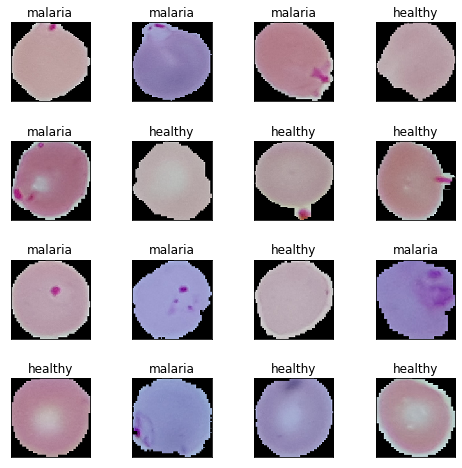

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [0]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 27
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])


['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [0]:
#!pip uninstall tensorflow

In [0]:
#!pip install tensorflow==2.0.0-beta1
!pip install keras

In [0]:
import tensorflow as tf
print(tf.__version__)

import keras as k
k.__version__

1.15.0


Using TensorFlow backend.


'2.2.5'

In [0]:
vgg = k.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)

vgg.trainable = False
# Freeze the layers
for layer in vgg.layers[:-3]:
    layer.trainable = False

base_vgg = vgg
base_out = base_vgg.output
pool_out = k.layers.Flatten()(base_out)
hidden1 = k.layers.Dense(512, activation='relu')(pool_out)
drop1 = k.layers.Dropout(rate=0.3)(hidden1)
hidden3 = k.layers.Dense(150, activation='relu')(drop1)
drop3 = k.layers.Dropout(rate=0.4)(hidden3)
out = k.layers.Dense(1, activation=k.activations.sigmoid)(drop3)
model = k.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=k.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 125, 125, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0  

In [0]:
import datetime
logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = k.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,  
                    verbose=1)
                    

Epoch 1/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.1658 - acc: 0.9450
Epoch 2/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.1479 - acc: 0.9501
Epoch 3/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.1371 - acc: 0.9539
Epoch 4/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.1284 - acc: 0.9577
Epoch 5/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.1162 - acc: 0.9615
Epoch 6/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.1074 - acc: 0.9656
Epoch 7/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.0998 - acc: 0.9675
Epoch 8/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.0902 - acc: 0.9715
Epoch 9/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.0856 - acc: 0.9730
Epoch 10/27
17361/17361 [==============================] - 19s 1ms/step - loss: 0.0800 - acc: 0.9756

In [0]:
model.evaluate(val_imgs_scaled, val_labels_enc,verbose=1)

1929/1929 [==============================] - 3s 1ms/step


[0.4279721785740354, 0.9450492483151892]

In [0]:
model.save('malariaNet.h5')

KeyError: ignored

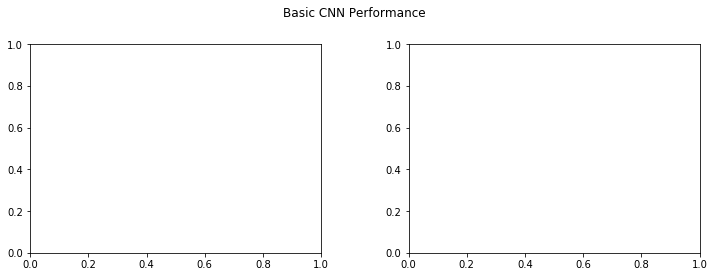

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
!pip install coremltools

     |████████████████████████████████| 3.4MB 2.8MB/s 


In [0]:
model = k.models.load_model('malariaNet.h5')

In [0]:
import coremltools

output_labels = ['healthy','malaria']
scale = 1/255.

coreml_model = coremltools.converters.keras.convert(model,
                                                   input_names='image',
                                                   image_input_names='image',
                                                   output_names='output',
                                                   class_labels=output_labels,
                                                   image_scale=scale)

coreml_model.author = 'Ferdinand Loesch'
coreml_model.license = 'MIT'
coreml_model.short_description = 'Model to classify blood samples of malaria'
coreml_model.input_description['image'] = 'cropped image of blood cell'
coreml_model.output_description['output'] = 'predicted if cell has malaria'

coreml_model.save('malariaNet.mlmodel')


0 : input_8, <keras.engine.input_layer.InputLayer object at 0x7f928e16f6d8>
1 : block1_conv1, <keras.layers.convolutional.Conv2D object at 0x7f928e16fb70>
2 : block1_conv1__activation__, <keras.layers.core.Activation object at 0x7f903ddd7198>
3 : block1_conv2, <keras.layers.convolutional.Conv2D object at 0x7f928e16fb38>
4 : block1_conv2__activation__, <keras.layers.core.Activation object at 0x7f903de190f0>
5 : block1_pool, <keras.layers.pooling.MaxPooling2D object at 0x7f928e10ba58>
6 : block2_conv1, <keras.layers.convolutional.Conv2D object at 0x7f928e119978>
7 : block2_conv1__activation__, <keras.layers.core.Activation object at 0x7f939e353160>
8 : block2_conv2, <keras.layers.convolutional.Conv2D object at 0x7f928e11f1d0>
9 : block2_conv2__activation__, <keras.layers.core.Activation object at 0x7f939e2f80f0>
10 : block2_pool, <keras.layers.pooling.MaxPooling2D object at 0x7f928e1255c0>
11 : block3_conv1, <keras.layers.convolutional.Conv2D object at 0x7f928e1249e8>
12 : block3_conv1__

In [0]:
from google.colab import files
#files.download('malariaNet.mlmodel')
files.download('malariaNet.h5')